In [14]:
import numpy as np 
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt

In [2]:
# Now let us load the two datasets and see how well it works 

model_input = xr.open_dataset('../Datasets/india_model_output_005deg_irregular_storm.nc')

obs_input = xr.open_dataset('../Datasets/india_obs_output_005deg_irregular_storm.nc')

In [3]:
model_input

<xarray.Dataset> Size: 65MB
Dimensions:            (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat                (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon                (lon) float64 5kB 68.0 68.05 68.1 ... 96.9 96.95 97.0
  * time               (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T2...
Data variables:
    lightning_density  (time, lat, lon) float64 65MB ...

In [4]:
obs_input

<xarray.Dataset> Size: 65MB
Dimensions:            (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat                (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon                (lon) float64 5kB 68.0 68.05 68.1 ... 96.9 96.95 97.0
  * time               (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T2...
Data variables:
    lightning_density  (time, lat, lon) float64 65MB ...

In [5]:
# Step 2: Basic Inspection
print("Model dataset info:")
print(model_input)

print("Observation dataset info:")
print(obs_input)

Model dataset info:
<xarray.Dataset> Size: 65MB
Dimensions:            (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat                (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon                (lon) float64 5kB 68.0 68.05 68.1 ... 96.9 96.95 97.0
  * time               (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T2...
Data variables:
    lightning_density  (time, lat, lon) float64 65MB ...
Observation dataset info:
<xarray.Dataset> Size: 65MB
Dimensions:            (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat                (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon                (lon) float64 5kB 68.0 68.05 68.1 ... 96.9 96.95 97.0
  * time               (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T2...
Data variables:
    lightning_density  (time, lat, lon) float64 65MB ...


In [6]:
## let us check the dataset compatibility 

def check_dataset_compatibility(model_ds, obs_ds):
    """
    Checks if both Datasets have the same dimensions and coordinate values 
    (lat, lon, time). Raises ValueError if something is incompatible.
    """
    
    required_dims = ['time', 'lat', 'lon']
    
    # 1. Check if required dims are in both Datasets
    for dim in required_dims:
        if dim not in model_ds.dims:
            raise ValueError(f"Model dataset is missing dimension: {dim}")
        if dim not in obs_ds.dims:
            raise ValueError(f"Observations dataset is missing dimension: {dim}")
            
    # 2. Check dimension sizes
    for dim in required_dims:
        model_size = model_ds.dims[dim]
        obs_size = obs_ds.dims[dim]
        if model_size != obs_size:
            raise ValueError(f"Dimension size mismatch for {dim}: model has {model_size}, obs has {obs_size}")
    
    # 3. Optional: Check coordinate values
    #    Are the lat/lon/time arrays exactly the same, or do we allow small differences?
    #    If you want to check exact equality, do something like:
    if not np.allclose(model_ds['lat'].values, obs_ds['lat'].values):
        raise ValueError("Latitude coordinates do not match.")
    if not np.allclose(model_ds['lon'].values, obs_ds['lon'].values):
        raise ValueError("Longitude coordinates do not match.")
    if not np.array_equal(model_ds['time'].values, obs_ds['time'].values):
        raise ValueError("Time coordinates do not match.")
    
    print("Dataset compatibility check: PASS")

# Run the compatibility check
check_dataset_compatibility(model_input, obs_input)


Dataset compatibility check: PASS


/tmp/ipykernel_131830/3691190779.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  model_size = model_ds.dims[dim]
/tmp/ipykernel_131830/3691190779.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  obs_size = obs_ds.dims[dim]


In [7]:
## Handle the missing values 

def check_missing_values(ds, var_name):
    """
    Checks for missing values (NaNs) in the given variable of a Dataset.
    Returns True if NaNs are found, otherwise False.
    """
    data = ds[var_name].values
    if np.isnan(data).any():
        return True
    return False

variable_name = 'lightning_density'  # The name of the variable in your Datasets

model_has_nans = check_missing_values(model_input, variable_name)
obs_has_nans = check_missing_values(obs_input, variable_name)

if model_has_nans or obs_has_nans:
    print(f"Warning: NaN values detected in {'model' if model_has_nans else ''} "
          f"{'obs' if obs_has_nans else ''} dataset(s).")
    # Optionally: Decide if you want to fill them or mask them out
    # e.g. ds[var_name] = ds[var_name].fillna(0) or ds[var_name].where(~np.isnan(ds[var_name]))
else:
    print("No missing values detected for both datasets.")


No missing values detected for both datasets.


In [8]:
## Computing metrics 

import math

def compute_basic_metrics(model_data, obs_data):
    """
    Compute common statistics to measure similarity between model and observed data.
    model_data, obs_data: xarray.DataArray or numpy array with identical shape
    """
    # Convert to numpy arrays if they are xarray DataArrays
    model_arr = model_data.values if hasattr(model_data, 'values') else model_data
    obs_arr = obs_data.values if hasattr(obs_data, 'values') else obs_data
    
    # Flatten to 1D for simplicity in calculations
    model_flat = model_arr.flatten()
    obs_flat = obs_arr.flatten()
    
    # 1. Mean Error (Bias)
    bias = np.mean(model_flat - obs_flat)
    
    # 2. Mean Absolute Error
    mae = np.mean(np.abs(model_flat - obs_flat))
    
    # 3. Root Mean Square Error
    rmse = math.sqrt(np.mean((model_flat - obs_flat)**2))
    
    # 4. Correlation Coefficient
    #    We can use np.corrcoef to get the correlation matrix, then take [0,1]
    corr_matrix = np.corrcoef(model_flat, obs_flat)
    r_value = corr_matrix[0,1]
    
    return {
        'bias': bias,
        'mae': mae,
        'rmse': rmse,
        'corr': r_value
    }


In [9]:
variable_name = 'lightning_density'

model_da = model_input[variable_name]
obs_da = obs_input[variable_name]

metrics = compute_basic_metrics(model_da, obs_da)

print("Comparison Metrics:")
print(f"Mean Error (Bias)     : {metrics['bias']:.4f}")
print(f"Mean Absolute Error   : {metrics['mae']:.4f}")
print(f"Root Mean Square Error: {metrics['rmse']:.4f}")
print(f"Correlation (Pearson): {metrics['corr']:.4f}")


Comparison Metrics:
Mean Error (Bias)     : -0.0000
Mean Absolute Error   : 0.0003
Root Mean Square Error: 0.0036
Correlation (Pearson): 0.7289


In [10]:
import xarray as xr
import numpy as np
import math

def validate_variable_existence(ds, var_name):
    if var_name not in ds.data_vars:
        raise KeyError(f"Variable '{var_name}' not found in dataset. "
                       f"Available variables: {list(ds.data_vars.keys())}")

def check_dataset_compatibility(model_ds, obs_ds, var_name):
    """
    Checks if both Datasets have the same dimensions (time, lat, lon)
    and coordinate values, and if the variable exists.
    """
    # 1. Validate variable existence
    validate_variable_existence(model_ds, var_name)
    validate_variable_existence(obs_ds, var_name)
    
    # 2. Check dimension existence
    required_dims = ['time', 'lat', 'lon']
    for dim in required_dims:
        if dim not in model_ds.dims:
            raise ValueError(f"Model dataset missing dimension: {dim}")
        if dim not in obs_ds.dims:
            raise ValueError(f"Observation dataset missing dimension: {dim}")
    
    # 3. Check dimension sizes
    for dim in required_dims:
        if model_ds.dims[dim] != obs_ds.dims[dim]:
            raise ValueError(
                f"Dimension size mismatch for {dim}: "
                f"model has {model_ds.dims[dim]}, obs has {obs_ds.dims[dim]}"
            )
    
    # 4. Check coordinate values (with tolerance for lat/lon)
    if not np.allclose(model_ds['lat'].values, obs_ds['lat'].values):
        raise ValueError("Latitude coordinates do not match.")
    if not np.allclose(model_ds['lon'].values, obs_ds['lon'].values):
        raise ValueError("Longitude coordinates do not match.")
    if not np.array_equal(model_ds['time'].values, obs_ds['time'].values):
        raise ValueError("Time coordinates do not match.")
    
    print("Dataset compatibility check: PASS")

def check_missing_values(ds, var_name):
    """
    Checks for missing values (NaNs) in the given variable of a Dataset.
    Returns True if NaNs are found, otherwise False.
    """
    data = ds[var_name].values
    return np.isnan(data).any()

def compute_basic_metrics(model_data, obs_data):
    """
    Compute common statistics: bias, mae, rmse, correlation
    """
    # Convert to numpy arrays if needed
    model_arr = model_data.values if hasattr(model_data, 'values') else model_data
    obs_arr = obs_data.values if hasattr(obs_data, 'values') else obs_data
    
    # Flatten to 1D
    model_flat = model_arr.flatten()
    obs_flat = obs_arr.flatten()
    
    bias = np.mean(model_flat - obs_flat)
    mae = np.mean(np.abs(model_flat - obs_flat))
    rmse = math.sqrt(np.mean((model_flat - obs_flat)**2))
    
    corr_matrix = np.corrcoef(model_flat, obs_flat)
    r_value = corr_matrix[0,1]
    
    return {'bias': bias, 'mae': mae, 'rmse': rmse, 'corr': r_value}


# ======================
#       MAIN SCRIPT
# ======================
if __name__ == "__main__":
    # Load the data
    model_input = xr.open_dataset('../Datasets/india_model_output_005deg_irregular_storm.nc')
    obs_input = xr.open_dataset('../Datasets/india_obs_output_005deg_irregular_storm.nc')
    
    # Define variable of interest
    variable_name = 'lightning_density'
    
    # 1. Check compatibility
    check_dataset_compatibility(model_input, obs_input, variable_name)
    
    # 2. Check for missing values
    model_has_nans = check_missing_values(model_input, variable_name)
    obs_has_nans = check_missing_values(obs_input, variable_name)
    if model_has_nans or obs_has_nans:
        print("Warning: Data contains missing values (NaNs). Consider filling or masking them.")
    
    # 3. Compute metrics
    model_da = model_input[variable_name]
    obs_da = obs_input[variable_name]
    
    metrics = compute_basic_metrics(model_da, obs_da)
    
    # 4. Print results
    print("=== Model vs. Obs Comparison ===")
    print(f"Variable: {variable_name}")
    print(f" Bias (Mean Error)     : {metrics['bias']:.4f}")
    print(f" MAE (Mean Absolute Error): {metrics['mae']:.4f}")
    print(f" RMSE                  : {metrics['rmse']:.4f}")
    print(f" Correlation (Pearson) : {metrics['corr']:.4f}")


/tmp/ipykernel_131830/1729034976.py:29: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if model_ds.dims[dim] != obs_ds.dims[dim]:


Dataset compatibility check: PASS
=== Model vs. Obs Comparison ===
Variable: lightning_density
 Bias (Mean Error)     : -0.0000
 MAE (Mean Absolute Error): 0.0003
 RMSE                  : 0.0036
 Correlation (Pearson) : 0.7289


In [11]:
import xarray as xr
import numpy as np
import math

def validate_variable_existence(ds, var_name):
    """
    Checks if the specified variable exists in the dataset. 
    Raises KeyError if not found.
    """
    if var_name not in ds.data_vars:
        raise KeyError(f"Variable '{var_name}' not found in dataset. "
                       f"Available variables: {list(ds.data_vars.keys())}")

def check_dataset_compatibility(model_ds, obs_ds, var_name):
    """
    Checks if both Datasets have the same dimensions (time, lat, lon) and
    coordinate values, and if the variable exists in both.
    Raises ValueError/KeyError if something is incompatible.
    """
    # 1. Validate variable existence
    validate_variable_existence(model_ds, var_name)
    validate_variable_existence(obs_ds, var_name)
    
    # 2. Check dimension existence
    required_dims = ['time', 'lat', 'lon']
    for dim in required_dims:
        if dim not in model_ds.dims:
            raise ValueError(f"Model dataset missing dimension: {dim}")
        if dim not in obs_ds.dims:
            raise ValueError(f"Observation dataset missing dimension: {dim}")
    
    # 3. Check dimension sizes
    for dim in required_dims:
        if model_ds.dims[dim] != obs_ds.dims[dim]:
            raise ValueError(
                f"Dimension size mismatch for {dim}: "
                f"model has {model_ds.dims[dim]}, obs has {obs_ds.dims[dim]}"
            )
    
    # 4. Check coordinate values (with tolerance for lat/lon)
    if not np.allclose(model_ds['lat'].values, obs_ds['lat'].values):
        raise ValueError("Latitude coordinates do not match.")
    if not np.allclose(model_ds['lon'].values, obs_ds['lon'].values):
        raise ValueError("Longitude coordinates do not match.")
    # For time, we often require an exact match (assuming the same time steps)
    if not np.array_equal(model_ds['time'].values, obs_ds['time'].values):
        raise ValueError("Time coordinates do not match.")
    
    print("Dataset compatibility check: PASS\n")

def check_missing_values(ds, var_name):
    """
    Checks for missing values (NaNs) in the given variable of a Dataset.
    Returns True if NaNs are found, otherwise False.
    """
    data = ds[var_name].values
    return np.isnan(data).any()

def global_stats(model_data, obs_data):
    """
    Compute global (domain-wide) stats as single numbers:
      - bias
      - mae
      - rmse
      - correlation (over entire 1D flattened array)
    Returns a dictionary with these single-value metrics.
    """
    model_arr = model_data.values.flatten()
    obs_arr   = obs_data.values.flatten()
    
    bias = np.mean(model_arr - obs_arr)
    mae  = np.mean(np.abs(model_arr - obs_arr))
    rmse = math.sqrt(np.mean((model_arr - obs_arr)**2))
    
    corr_matrix = np.corrcoef(model_arr, obs_arr)
    corr_value  = corr_matrix[0, 1]
    
    return {
        'bias' : bias,
        'mae'  : mae,
        'rmse' : rmse,
        'corr' : corr_value
    }

def compute_gridwise_metrics(model_data, obs_data):
    """
    Compute per-gridpoint difference and absolute difference:
      - difference = model - obs (shape: [time, lat, lon])
      - abs_diff   = |model - obs| (shape: [time, lat, lon])
    Also compute correlation across the time dimension for each lat-lon:
      - correlation(time-wise) => shape: [lat, lon]
      
    Returns an xarray.Dataset containing:
      - 'difference'   (time, lat, lon)
      - 'abs_difference' (time, lat, lon)
      - 'corr' (lat, lon)
    """
    # difference across (time, lat, lon)
    difference = model_data - obs_data
    abs_difference = np.abs(difference)
    
    # correlation across time dimension for each lat-lon
    # (We assume time is the first dimension, so we'll apply the formula carefully.)
    # correlation = covariance(X, Y) / (std(X)*std(Y))
    # where X, Y are time series for each lat-lon pixel.
    # We'll compute this with a simple formula and xarray's groupby approach.

    # Approach 1: Manual correlation using xarray's mean/std for each lat-lon
    #   r = ( (X - mean(X))*(Y - mean(Y)) ).mean(dim="time") / (std(X)*std(Y))

    # Step 1: compute the means along time
    model_mean = model_data.mean(dim='time')
    obs_mean   = obs_data.mean(dim='time')
    
    # Step 2: compute anomalies
    model_anom = model_data - model_mean
    obs_anom   = obs_data - obs_mean
    
    # Step 3: compute covariance along time
    cov = (model_anom * obs_anom).mean(dim='time')
    
    # Step 4: compute std dev along time
    model_std = model_data.std(dim='time')
    obs_std   = obs_data.std(dim='time')
    
    # Step 5: correlation
    corr = cov / (model_std * obs_std)
    
    # Package them into a new Dataset
    metrics_ds = xr.Dataset(
        {
            "difference": difference,          # 3D: time x lat x lon
            "abs_difference": abs_difference,  # 3D: time x lat x lon
            "corr": corr                       # 2D: lat x lon
        },
        coords=model_data.coords,  # This includes time, lat, lon
        attrs={
            "description": "Per-gridpoint comparison metrics",
            "note": "difference = model - obs, corr is time-wise correlation for each lat-lon"
        }
    )
    
    # For 'corr', it doesn't make sense to store it across the 'time' dimension, 
    # because we've collapsed it in the correlation calculation. 
    # So, 'corr' will automatically only have [lat, lon]. 
    # xarray will handle the mismatch in dimensions gracefully.
    
    return metrics_ds

if __name__ == "__main__":
    # 1. Load the data
    model_input = xr.open_dataset('../Datasets/india_model_output_005deg_irregular_storm.nc')
    obs_input   = xr.open_dataset('../Datasets/india_obs_output_005deg_irregular_storm.nc')
    
    # Define the variable we want to compare
    variable_name = 'lightning_density'
    
    # 2. Check dataset compatibility (dims, coords, variable existence)
    check_dataset_compatibility(model_input, obs_input, variable_name)
    
    # 3. Check for NaNs and optionally handle or warn
    model_has_nans = check_missing_values(model_input, variable_name)
    obs_has_nans   = check_missing_values(obs_input, variable_name)
    if model_has_nans or obs_has_nans:
        print(f"Warning: NaN values detected in "
              f"{'model' if model_has_nans else ''} "
              f"{'obs' if obs_has_nans else ''} data.")
        print("You may want to fill or mask these values before proceeding.\n")
    
    # 4. Extract the DataArrays for easier manipulation
    model_da = model_input[variable_name]
    obs_da   = obs_input[variable_name]
    
    # 5. Compute global (single-value) statistics
    stats = global_stats(model_da, obs_da)
    print("=== Global Statistics (Domain-Wide) ===")
    print(f"  Bias  (model - obs): {stats['bias']:.4f}")
    print(f"  MAE                : {stats['mae']:.4f}")
    print(f"  RMSE               : {stats['rmse']:.4f}")
    print(f"  Correlation        : {stats['corr']:.4f}\n")
    
    # 6. Compute per-gridpoint metrics (difference, abs difference, correlation)
    metrics_ds = compute_gridwise_metrics(model_da, obs_da)
    
    # 7. Save the comparison dataset as a NetCDF file
    output_path = "comparison_metrics.nc"
    metrics_ds.to_netcdf(output_path)
    print(f"Saved gridwise comparison metrics to {output_path}\n")
    
    # 8. (Optional) Summarize or show the contents of the resulting dataset
    print("=== Comparison Metrics Dataset (preview) ===")
    print(metrics_ds)


/tmp/ipykernel_131830/3701745503.py:34: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if model_ds.dims[dim] != obs_ds.dims[dim]:


Dataset compatibility check: PASS

=== Global Statistics (Domain-Wide) ===
  Bias  (model - obs): -0.0000
  MAE                : 0.0003
  RMSE               : 0.0036
  Correlation        : 0.7289

Saved gridwise comparison metrics to comparison_metrics.nc

=== Comparison Metrics Dataset (preview) ===
<xarray.Dataset> Size: 132MB
Dimensions:         (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat             (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon             (lon) float64 5kB 68.0 68.05 68.1 68.15 ... 96.9 96.95 97.0
  * time            (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T23:0...
Data variables:
    difference      (time, lat, lon) float64 65MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    abs_difference  (time, lat, lon) float64 65MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    corr            (lat, lon) float64 3MB nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Per-gridpoint comparison metrics
    note:         difference = model - obs, corr is ti

In [12]:
metrics_ds

<xarray.Dataset> Size: 132MB
Dimensions:         (lat: 581, lon: 581, time: 24)
Coordinates:
  * lat             (lat) float64 5kB 8.0 8.05 8.1 8.15 ... 36.9 36.95 37.0
  * lon             (lon) float64 5kB 68.0 68.05 68.1 68.15 ... 96.9 96.95 97.0
  * time            (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T23:0...
Data variables:
    difference      (time, lat, lon) float64 65MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    abs_difference  (time, lat, lon) float64 65MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    corr            (lat, lon) float64 3MB nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Per-gridpoint comparison metrics
    note:         difference = model - obs, corr is time-wise correlation for...

/tmp/ipykernel_131830/3121457889.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if model_ds.dims[dim] != obs_ds.dims[dim]:


Dataset compatibility check: PASS

=== Global (Domain-Wide) Statistics ===
  Bias (model - obs): -0.0000
  MAE               : 0.0003
  RMSE              : 0.0036
  Correlation       : 0.7289

Saved gridwise comparison metrics to comparison_metrics.nc

Generating visualizations...


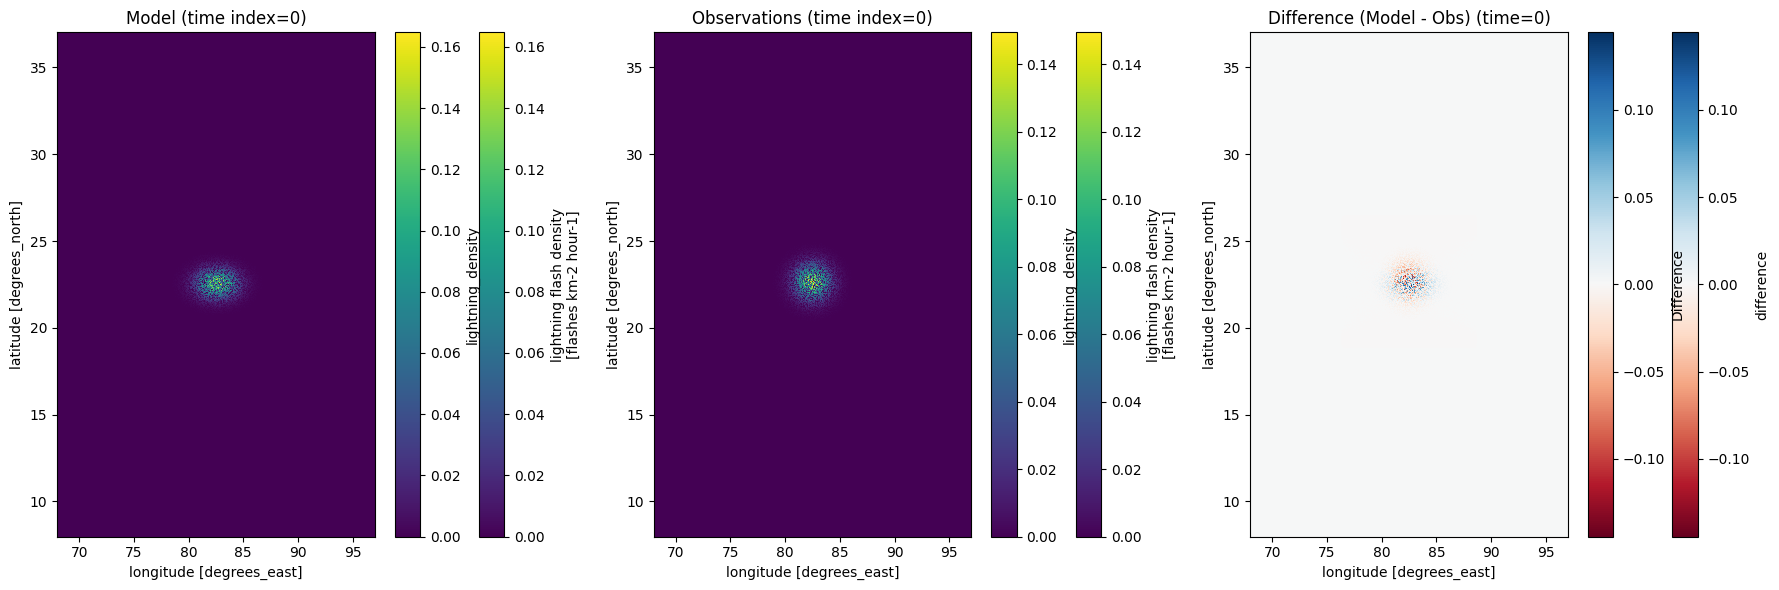

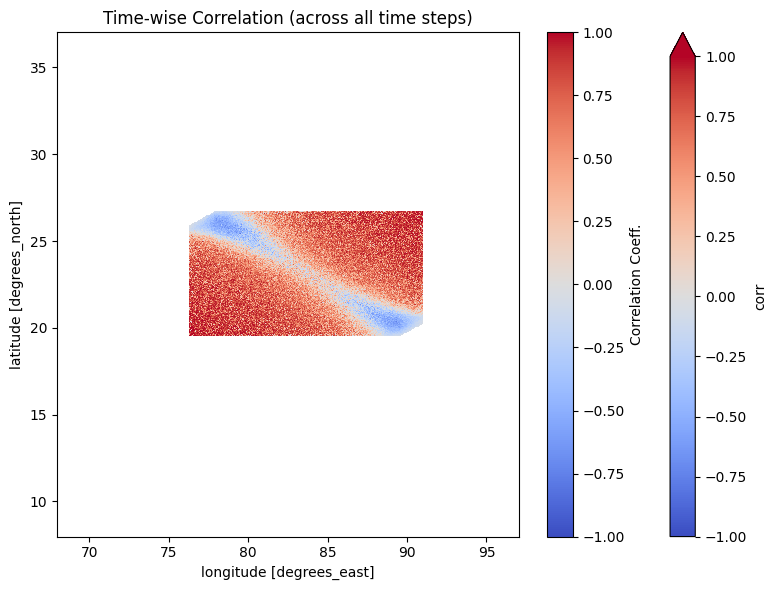

In [16]:
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt

def validate_variable_existence(ds, var_name):
    """
    Checks if the specified variable exists in the dataset. 
    Raises KeyError if not found.
    """
    if var_name not in ds.data_vars:
        raise KeyError(f"Variable '{var_name}' not found in dataset. "
                       f"Available variables: {list(ds.data_vars.keys())}")

def check_dataset_compatibility(model_ds, obs_ds, var_name):
    """
    Checks if both Datasets have the same dimensions (time, lat, lon) and
    coordinate values, and if the variable exists in both.
    Raises ValueError/KeyError if something is incompatible.
    """
    # 1. Validate variable existence
    validate_variable_existence(model_ds, var_name)
    validate_variable_existence(obs_ds, var_name)
    
    # 2. Check dimension existence
    required_dims = ['time', 'lat', 'lon']
    for dim in required_dims:
        if dim not in model_ds.dims:
            raise ValueError(f"Model dataset missing dimension: {dim}")
        if dim not in obs_ds.dims:
            raise ValueError(f"Observation dataset missing dimension: {dim}")
    
    # 3. Check dimension sizes
    for dim in required_dims:
        if model_ds.dims[dim] != obs_ds.dims[dim]:
            raise ValueError(
                f"Dimension size mismatch for {dim}: "
                f"model has {model_ds.dims[dim]}, obs has {obs_ds.dims[dim]}"
            )
    
    # 4. Check coordinate values (with tolerance for lat/lon)
    if not np.allclose(model_ds['lat'].values, obs_ds['lat'].values):
        raise ValueError("Latitude coordinates do not match.")
    if not np.allclose(model_ds['lon'].values, obs_ds['lon'].values):
        raise ValueError("Longitude coordinates do not match.")
    # For time, we typically require an exact match (assuming same time steps)
    if not np.array_equal(model_ds['time'].values, obs_ds['time'].values):
        raise ValueError("Time coordinates do not match.")
    
    print("Dataset compatibility check: PASS\n")

def check_missing_values(ds, var_name):
    """
    Checks for missing values (NaNs) in the given variable of a Dataset.
    Returns True if NaNs are found, otherwise False.
    """
    data = ds[var_name].values
    return np.isnan(data).any()

def global_stats(model_data, obs_data):
    """
    Compute global (domain-wide) stats as single numbers:
      - bias
      - mae
      - rmse
      - correlation (over entire 1D flattened array)
    Returns a dictionary with these single-value metrics.
    """
    model_arr = model_data.values.flatten()
    obs_arr   = obs_data.values.flatten()
    
    bias = np.mean(model_arr - obs_arr)
    mae  = np.mean(np.abs(model_arr - obs_arr))
    rmse = math.sqrt(np.mean((model_arr - obs_arr)**2))
    
    corr_matrix = np.corrcoef(model_arr, obs_arr)
    corr_value  = corr_matrix[0, 1]
    
    return {
        'bias' : bias,
        'mae'  : mae,
        'rmse' : rmse,
        'corr' : corr_value
    }

def compute_gridwise_metrics(model_data, obs_data):
    """
    Compute per-gridpoint difference and absolute difference:
      - difference = model - obs (time, lat, lon)
      - abs_difference = |model - obs| (time, lat, lon)
    Also compute correlation across the time dimension for each lat-lon:
      - correlation => shape: (lat, lon)
    """
    # difference across (time, lat, lon)
    difference = model_data - obs_data
    abs_difference = np.abs(difference)
    
    # correlation across time dimension for each lat-lon
    model_mean = model_data.mean(dim='time')
    obs_mean   = obs_data.mean(dim='time')
    
    # compute anomalies
    model_anom = model_data - model_mean
    obs_anom   = obs_data - obs_mean
    
    # covariance along time
    cov = (model_anom * obs_anom).mean(dim='time')
    
    # standard deviations along time
    model_std = model_data.std(dim='time')
    obs_std   = obs_data.std(dim='time')
    
    # correlation
    corr = cov / (model_std * obs_std)
    
    # Package them into a new Dataset
    metrics_ds = xr.Dataset(
        {
            "difference": difference,          # 3D: time x lat x lon
            "abs_difference": abs_difference,  # 3D: time x lat x lon
            "corr": corr                       # 2D: lat x lon
        },
        coords=model_data.coords,  # This includes time, lat, lon
        attrs={
            "description": "Per-gridpoint comparison metrics",
            "note": "difference = model - obs, corr is time-wise correlation for each lat-lon"
        }
    )
    return metrics_ds

def visualize_comparison(model_data, obs_data, metrics_ds, time_step=0):
    """
    Visualizes:
      1) Model field at a given time step
      2) Observation field at the same time step
      3) (Model - Obs) difference for that time step
      4) Correlation map over lat-lon (computed across the entire time dimension)
    """
    # --- Figure 1: Model, Obs, and Difference maps for a chosen time step ---
    plt.figure(figsize=(18, 6))
    
    # Subplot 1: Model
    ax1 = plt.subplot(1, 3, 1)
    model_slice = model_data.isel(time=time_step)
    im1 = model_slice.plot(ax=ax1, x='lon', y='lat', cmap='viridis')
    ax1.set_title(f"Model (time index={time_step})")
    plt.colorbar(im1, ax=ax1, orientation='vertical', label=str(model_data.name))
    
    # Subplot 2: Observations
    ax2 = plt.subplot(1, 3, 2)
    obs_slice = obs_data.isel(time=time_step)
    im2 = obs_slice.plot(ax=ax2, x='lon', y='lat', cmap='viridis')
    ax2.set_title(f"Observations (time index={time_step})")
    plt.colorbar(im2, ax=ax2, orientation='vertical', label=str(obs_data.name))
    
    # Subplot 3: Difference (Model - Obs)
    ax3 = plt.subplot(1, 3, 3)
    diff_slice = metrics_ds['difference'].isel(time=time_step)
    im3 = diff_slice.plot(ax=ax3, x='lon', y='lat', cmap='RdBu', center=0)
    ax3.set_title(f"Difference (Model - Obs) (time={time_step})")
    plt.colorbar(im3, ax=ax3, orientation='vertical', label='Difference')
    
    plt.tight_layout()
    plt.show()
    
    # --- Figure 2: Time-wise Correlation map ---
    # correlation is 2D (lat, lon)
    plt.figure(figsize=(8, 6))
    corr = metrics_ds['corr']
    im4 = corr.plot(x='lon', y='lat', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Time-wise Correlation (across all time steps)")
    plt.colorbar(im4, orientation='vertical', label='Correlation Coeff.')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # ==============
    #   LOAD DATA
    # ==============
    model_input = xr.open_dataset('../Datasets/india_model_output_005deg_irregular_storm.nc')
    obs_input   = xr.open_dataset('../Datasets/india_obs_output_005deg_irregular_storm.nc')
    
    # Variable to compare
    variable_name = 'lightning_density'
    
    # ==============
    # CHECKS
    # ==============
    # 1. Dataset compatibility
    check_dataset_compatibility(model_input, obs_input, variable_name)
    
    # 2. NaN checks
    model_has_nans = check_missing_values(model_input, variable_name)
    obs_has_nans   = check_missing_values(obs_input, variable_name)
    if model_has_nans or obs_has_nans:
        print("Warning: NaN values detected in data. Consider filling/masking them.\n")
    
    # ==============
    # COMPUTE METRICS
    # ==============
    # Extract DataArrays for convenience
    model_da = model_input[variable_name]
    obs_da   = obs_input[variable_name]
    
    # A) Global (single-value) Stats
    stats = global_stats(model_da, obs_da)
    print("=== Global (Domain-Wide) Statistics ===")
    print(f"  Bias (model - obs): {stats['bias']:.4f}")
    print(f"  MAE               : {stats['mae']:.4f}")
    print(f"  RMSE              : {stats['rmse']:.4f}")
    print(f"  Correlation       : {stats['corr']:.4f}\n")
    
    # B) Gridwise Metrics
    metrics_ds = compute_gridwise_metrics(model_da, obs_da)
    
    # ==============
    # SAVE RESULTS
    # ==============
    output_path = "comparison_metrics.nc"
    metrics_ds.to_netcdf(output_path)
    print(f"Saved gridwise comparison metrics to {output_path}\n")
    
    # ==============
    # VISUALIZATION
    # ==============
    print("Generating visualizations...")
    # Visualize at time step 0 (change as desired, or loop over multiple time steps)
    visualize_comparison(model_da, obs_da, metrics_ds, time_step=0)
